### DSC 478 - Final Project
### Arun Gopal Govindaswamy


In [35]:
import pandas as pd
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import graphviz
from sklearn.tree import export_graphviz

In [2]:
x_train = pd.read_csv("isolet1+2+3+4.data", header = None)
y_train = x_train.pop(617)
x_test = pd.read_csv("isolet5.data", header = None)
y_test = x_test.pop(617)
print("Train data shape: {}\nTrain labels shape: {}\nTest data shape: {}\nTest labels shape: {}".format(x_train.shape,y_train.shape,x_test.shape,y_test.shape))

Train data shape: (6238, 617)
Train labels shape: (6238,)
Test data shape: (1559, 617)
Test labels shape: (1559,)


### KDD - Data Cleaning Step

**Checking for null values**

In [4]:
print("Number of null entries in the training data set:",x_train.isnull().sum().sum())
print("Number of null entries in the test data set:",x_test.isnull().sum().sum())

Number of null entries in the training data set: 0
Number of null entries in the test data set: 0


There are no null values in both train and test data.

### KDD - Data Selection and Transformation Step

**Data Description**

In [5]:
print(x_train.describe())

               0            1    ...          615          616
count  6238.000000  6238.000000  ...  6238.000000  6238.000000
mean     -0.394077     0.141918  ...     0.082916    -0.272561
std       0.240579     0.322356  ...     0.336243     0.357741
min      -1.000000    -0.892600  ...    -0.802800    -0.962600
25%      -0.555200    -0.100800  ...    -0.156700    -0.541350
50%      -0.423000     0.106600  ...     0.046800    -0.318200
75%      -0.248450     0.355550  ...     0.296100    -0.054000
max       1.000000     1.000000  ...     1.000000     0.889800

[8 rows x 617 columns]


It is seen from the top and bottom 10 columns that the data is already normalized and the values lie between -1 and 1. Let us confirm this by printing minimum and maximum of each column in the data set.

In [6]:
for index in x_train.columns:
    print("Column Index: {} \t Minimum: {:.2f} \t Maximum: {}".format(index,x_train[index].min(),x_train[index].max()))

Column Index: 0 	 Minimum: -1.00 	 Maximum: 1.0
Column Index: 1 	 Minimum: -0.89 	 Maximum: 1.0
Column Index: 2 	 Minimum: -0.98 	 Maximum: 1.0
Column Index: 3 	 Minimum: -0.97 	 Maximum: 1.0
Column Index: 4 	 Minimum: -1.00 	 Maximum: 1.0
Column Index: 5 	 Minimum: -0.98 	 Maximum: 1.0
Column Index: 6 	 Minimum: -1.00 	 Maximum: 1.0
Column Index: 7 	 Minimum: -1.00 	 Maximum: 1.0
Column Index: 8 	 Minimum: -1.00 	 Maximum: 1.0
Column Index: 9 	 Minimum: -1.00 	 Maximum: 1.0
Column Index: 10 	 Minimum: -1.00 	 Maximum: 1.0
Column Index: 11 	 Minimum: -0.99 	 Maximum: 1.0
Column Index: 12 	 Minimum: -0.97 	 Maximum: 1.0
Column Index: 13 	 Minimum: -0.98 	 Maximum: 1.0
Column Index: 14 	 Minimum: -0.99 	 Maximum: 1.0
Column Index: 15 	 Minimum: -0.97 	 Maximum: 1.0
Column Index: 16 	 Minimum: -0.98 	 Maximum: 1.0
Column Index: 17 	 Minimum: -0.92 	 Maximum: 1.0
Column Index: 18 	 Minimum: -0.96 	 Maximum: 1.0
Column Index: 19 	 Minimum: -1.00 	 Maximum: 1.0
Column Index: 20 	 Minimum: -0

All the feature values lie between -1 and +1. And, hence we do not need any more normalization.

### KDD - Data Mining and Pattern Recogntion step

**Clustering - KMeans**

In [29]:
kmeans = KMeans(n_clusters=26, random_state=0).fit(x_train)
y_train_pred = kmeans.predict(x_train)
y_test_pred = kmeans.predict(x_test)

print("Training Accuracy: {:.3f} Testing Accuracy: {:.3f}".format(accuracy_score(y_train,y_train_pred),accuracy_score(y_test,y_test_pred)))

Training Accuracy: 0.018 Testing Accuracy: 0.017


KMeans clustering failed terribly on our dataset. Let's try doing classification.

**Classification - KNearest Neighbor Algorithm**

In [7]:
neigh = KNeighborsClassifier()
neigh.fit(x_train, y_train)
print("Training Accuracy: {:.3f} Testing Accuracy: {:.3f}".format(neigh.score(x_train,y_train),neigh.score(x_test,y_test)))

Training Accuracy: 0.933 Testing Accuracy: 0.913


That was a very good start to classify. We got 93.3% on train and 91.3% on test data which is great considering this is a multi class classification problem. We also do not see evidence of overfitting. 

We achieved this high accuracy with a default parameters. We will try tuning the model with hyper-parameters.

In [18]:
parameters = {'n_neighbors': range(1,51,2),'p':[1,2]}
neigh = KNeighborsClassifier()
gs_neigh = GridSearchCV(neigh, parameters, n_jobs=-1,cv=5)
start = time.time()
gs_neigh.fit(x_train,y_train)
print("Total time:",time.time()-start)
print("Best Cross-Validation Score: {:.3f}\nTest Score: {:.3f}\nBest Parameters: {}".format(gs_neigh.best_score_,gs_neigh.score(x_test, y_test) ,gs_neigh.best_params_))

Total time: 1295.4524528980255
Best Cross-Validation Score: 0.909
Test Score: 0.915
Best Parameters: {'n_neighbors': 11, 'p': 2}


We increased the performance on the test data marginally. Let's try a different classifier to see if it helps.

**Classification - Decision Tree Classifier**

In [22]:
parameters = {'max_features': [None,'sqrt','log2'], 'criterion':['gini','entropy'],'max_depth': [5,10,15,None]}
DT =  DecisionTreeClassifier()
gs_dt = GridSearchCV(DT, parameters, n_jobs=-1,cv=5)
start = time.time()
gs_dt.fit(x_train,y_train)
print("Total time:",time.time()-start)
print("Best Cross-Validation Score: {:.3f}\nTest Score: {:.3f}\nBest Parameters: {}".format(gs_dt.best_score_,gs_dt.score(x_test, y_test) ,gs_dt.best_params_))

Total time: 231.60716485977173
Best Cross-Validation Score: 0.809
Test Score: 0.817
Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None}


A singel decision tree did not work in our favour. The performance was lower than that of a KNN algorithm. Hence, experimenting if an ensemble of trees such as the random forest classifier produce better performance.

**Classification - Random Forest Classifier**

In [48]:
rf_clf =  RandomForestClassifier(n_estimators = 100)
start = time.time()
rf_clf.fit(x_train,y_train)
print("Total time:",time.time()-start)
print("Training Score: {:.3f}\nTest Score: {:.3f}".format(rf_clf.score(x_train, y_train),rf_clf.score(x_test, y_test)))

Total time: 12.777966260910034
Training Score: 1.000
Test Score: 0.945


We could see some clear evidence of overfitting here. Let us deal with overfitting by early pruning. Playing with the maximum depth of the tree, and number of samples for leaf and node split can reduce overfitting

In [49]:
parameters = {'n_estimators':[100],'max_depth': [5,6,7,8,9,10], 'min_samples_split': range(1,10), 'min_samples_leaf': range(1,10)}
rf =  RandomForestClassifier()
gs_rf = GridSearchCV(rf, parameters, n_jobs=-1,cv=2, verbose = 8)
start = time.time()
gs_rf.fit(x_train,y_train)
print("Total time:",time.time()-start)
print("Best Cross-Validation Score: {:.3f}\nTest Score: {:.3f}\nBest Parameters: {}".format(gs_rf.best_score_,gs_rf.score(x_test, y_test) ,gs_rf.best_params_))

Fitting 2 folds for each of 486 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 757 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 41

Total time: 2487.3155903816223
Best Cross-Validation Score: 0.923
Test Score: 0.937
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}


In [50]:
print("Training Score: {:.3f}\nTest Score: {:.3f}".format(gs_rf.score(x_train, y_train),gs_rf.score(x_test, y_test)))

Training Score: 0.980
Test Score: 0.937


We were able to produce a random forest classifier capabale of predicting the spoken letter with 93.7% accuracy.

Let's also try having different number of features for the decision tree

In [3]:
parameters = {'n_estimators':[100],'max_depth': [10], 'min_samples_leaf': [6], 'max_features':['sqrt',None,'log2',100,200,300,400]}
rf =  RandomForestClassifier()
gs_rf = GridSearchCV(rf, parameters, n_jobs=-1,cv=2, verbose = 8)
start = time.time()
gs_rf.fit(x_train,y_train)
print("Total time:",time.time()-start)
print("Best Cross-Validation Score: {:.3f}\nTest Score: {:.3f}\nBest Parameters: {}".format(gs_rf.best_score_,gs_rf.score(x_test, y_test) ,gs_rf.best_params_))
print("Training Score: {:.3f}\nTest Score: {:.3f}".format(gs_rf.score(x_train, y_train),gs_rf.score(x_test, y_test)))

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:   10.1s remaining:   37.4s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:   35.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  1.8min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  2.6min remaining:   41.7s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  3.0min finished


Total time: 187.66743755340576
Best Cross-Validation Score: 0.920
Test Score: 0.923
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 100}
Training Score: 0.970
Test Score: 0.923


### KDD - Data Transformation Step

**Principal Component Analysis**

Text(0.5, 1.0, 'Cumulative variance explained by the components')

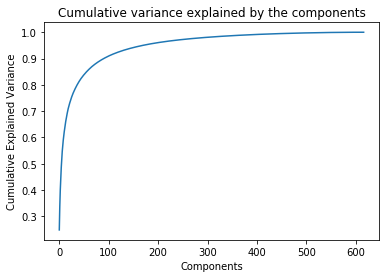

In [56]:
pca = PCA().fit(x_train)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative variance explained by the components")

In [22]:
pca.explained_variance_ratio_.cumsum()[:91]

array([0.24847975, 0.33739595, 0.40026603, 0.4460129 , 0.48649971,
       0.51959315, 0.54744809, 0.56974244, 0.58939642, 0.60701602,
       0.62152517, 0.63500892, 0.64822245, 0.66076165, 0.67185615,
       0.68199269, 0.69170958, 0.70091314, 0.70940018, 0.71667807,
       0.72364743, 0.73027903, 0.73643344, 0.74241866, 0.7482144 ,
       0.75367647, 0.75884138, 0.76396299, 0.76845544, 0.77278512,
       0.77706939, 0.78116108, 0.78502409, 0.78885333, 0.79262743,
       0.79622529, 0.79968735, 0.80307554, 0.80639333, 0.8095815 ,
       0.8126276 , 0.81559989, 0.81847533, 0.8212907 , 0.82404664,
       0.82661667, 0.82915787, 0.83163867, 0.8340481 , 0.8363711 ,
       0.83864654, 0.84091917, 0.84309659, 0.84525873, 0.84733192,
       0.84937512, 0.8513972 , 0.85336229, 0.85527727, 0.85718053,
       0.85902855, 0.86082587, 0.86260216, 0.86435178, 0.86605443,
       0.8677337 , 0.86938508, 0.87095557, 0.87251659, 0.87402955,
       0.87551469, 0.87694985, 0.87836447, 0.87976152, 0.88113

With 91 components, we are able to capture 90% variance in the data. Hence, we are now going to train a random forest classifier using these 91 components of data.

In [24]:
x_train_transform = pca.transform(x_train)
x_test_transform = pca.transform(x_test)

In [25]:
rf_clf_2 =  RandomForestClassifier(n_estimators = 100)
start = time.time()
rf_clf_2.fit(x_train_transform,y_train)
print("Total time:",time.time()-start)
print("Training Score: {:.3f}\nTest Score: {:.3f}".format(rf_clf_2.score(x_train_transform, y_train),rf_clf_2.score(x_test_transform, y_test)))

Total time: 39.346816301345825
Training Score: 1.000
Test Score: 0.870


Once again we see evidence of overfitting, hence we try and reduce overfitting by early pruning

In [26]:
parameters = {'n_estimators':[100],'max_depth': [5,6,7,8,9,10], 'min_samples_split': range(1,10), 'min_samples_leaf': range(1,10)}
rf_2 =  RandomForestClassifier()
gs_rf_2 = GridSearchCV(rf_2, parameters, n_jobs=-1,cv=2, verbose = 8)
start = time.time()
gs_rf_2.fit(x_train_transform,y_train)
print("Total time:",time.time()-start)
print("Best Cross-Validation Score: {:.3f}\nTest Score: {:.3f}\nBest Parameters: {}".format(gs_rf_2.best_score_,gs_rf_2.score(x_test_transform, y_test) ,gs_rf_2.best_params_))
print("Training Score: {:.3f}\nTest Score: {:.3f}".format(gs_rf_2.score(x_train_transform, y_train),gs_rf_2.score(x_test_transform, y_test)))

Fitting 2 folds for each of 486 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 24.5min finished


Total time: 1498.542587518692
Best Cross-Validation Score: 0.860
Test Score: 0.881
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 100}
Training Score: 0.991
Test Score: 0.881


The gap between training and test score were reduced. Whereas, the performance is still low compared to earlier implementation without pca. So let's tune for number of estimators and number of features to be used.

In [27]:
parameters = {'n_estimators':[100,200,300,400],'max_depth': [10,15,None], 'min_samples_split': [4], 'min_samples_leaf': [7], 'max_features':['auto',None,'sqrt',50]}
rf_2 =  RandomForestClassifier()
gs_rf_2 = GridSearchCV(rf_2, parameters, n_jobs=-1,cv=2, verbose = 8)
start = time.time()
gs_rf_2.fit(x_train_transform,y_train)
print("Total time:",time.time()-start)
print("Best Cross-Validation Score: {:.3f}\nTest Score: {:.3f}\nBest Parameters: {}".format(gs_rf_2.best_score_,gs_rf_2.score(x_test_transform, y_test) ,gs_rf_2.best_params_))
print("Training Score: {:.3f}\nTest Score: {:.3f}".format(gs_rf_2.score(x_train_transform, y_train),gs_rf_2.score(x_test_transform, y_test)))

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done  94 out of  96 | elapsed: 53.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 58.9min finished


Total time: 3661.9027676582336
Best Cross-Validation Score: 0.894
Test Score: 0.917
Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 400}
Training Score: 1.000
Test Score: 0.917


With 400 trees, we were able to produce 91.7% accuracy on the test data. There is some overfitting here. Let's tune for early pruning here.

In [33]:
parameters = {'n_estimators':[400],'max_depth': [5,10], 'min_samples_split': [15,20], 'min_samples_leaf': [20,15], 'max_features':['auto']}
rf_2 =  RandomForestClassifier()
gs_rf_2 = GridSearchCV(rf_2, parameters, n_jobs=-1,cv=2, verbose = 8)
start = time.time()
gs_rf_2.fit(x_train_transform,y_train)
print("Total time:",time.time()-start)
print("Best Cross-Validation Score: {:.3f}\nTest Score: {:.3f}\nBest Parameters: {}".format(gs_rf_2.best_score_,gs_rf_2.score(x_test_transform, y_test) ,gs_rf_2.best_params_))
print("Training Score: {:.3f}\nTest Score: {:.3f}".format(gs_rf_2.score(x_train_transform, y_train),gs_rf_2.score(x_test_transform, y_test)))

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  16 | elapsed:   38.6s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   39.0s remaining:   50.2s
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:  1.6min remaining:   56.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  1.6min remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.6min finished


Total time: 202.0773777961731
Best Cross-Validation Score: 0.884
Test Score: 0.896
Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 20, 'n_estimators': 400}
Training Score: 0.986
Test Score: 0.896


Even after extensive search for hyper-parameters, our model was not able to produce better results than the random forest classifier trained on original untransformed data.
And hence, we will be using only the original dataset from here on.

### KDD - Predictive modelling step

**Random Forest Classifier with original features**

In [57]:
rf_clf =  RandomForestClassifier(n_estimators = 100, max_depth=10, min_samples_split=6, min_samples_leaf=1)
start = time.time()
rf_clf.fit(x_train,y_train)
print("Total time:",time.time()-start)
print("Training Score: {:.3f}\nTest Score: {:.3f}".format(rf_clf.score(x_train, y_train),rf_clf.score(x_test, y_test)))

Total time: 22.294711351394653
Training Score: 0.980
Test Score: 0.938


The highest performance on test data wsa 93.8% using the random forest classifier and original data without any transformation.

### KDD - Knowledge Discovery Step 

In [52]:
rf_clf.feature_importances_

array([5.59427000e-05, 1.62637587e-04, 5.66410839e-04, 2.82688204e-03,
       4.73613660e-04, 5.58388080e-04, 1.98271634e-04, 3.20789251e-04,
       5.91325996e-03, 4.15720387e-03, 2.04623235e-03, 7.39718752e-04,
       7.49848101e-04, 2.84992402e-03, 4.35092023e-03, 5.02085671e-03,
       6.58199675e-04, 2.56878351e-04, 2.62720057e-04, 1.58419386e-04,
       2.94693022e-04, 2.08534451e-04, 4.25393582e-05, 8.99330507e-05,
       2.68250251e-05, 1.73344438e-04, 7.85589937e-05, 1.15261871e-04,
       2.74612274e-04, 1.53949504e-04, 8.22463602e-05, 4.83832993e-05,
       4.76945437e-05, 1.61712333e-04, 1.45459869e-04, 4.00355420e-04,
       1.99676384e-04, 2.18344765e-04, 7.00787417e-05, 1.92195695e-04,
       1.79842439e-04, 1.35353120e-04, 5.75693614e-05, 1.06712539e-04,
       3.72652315e-04, 2.79849551e-03, 1.22767450e-03, 3.56686728e-04,
       2.74179849e-04, 2.48201778e-04, 2.45374758e-04, 7.70557327e-05,
       1.74980897e-04, 1.00802964e-04, 8.20911961e-05, 4.93186349e-05,
      

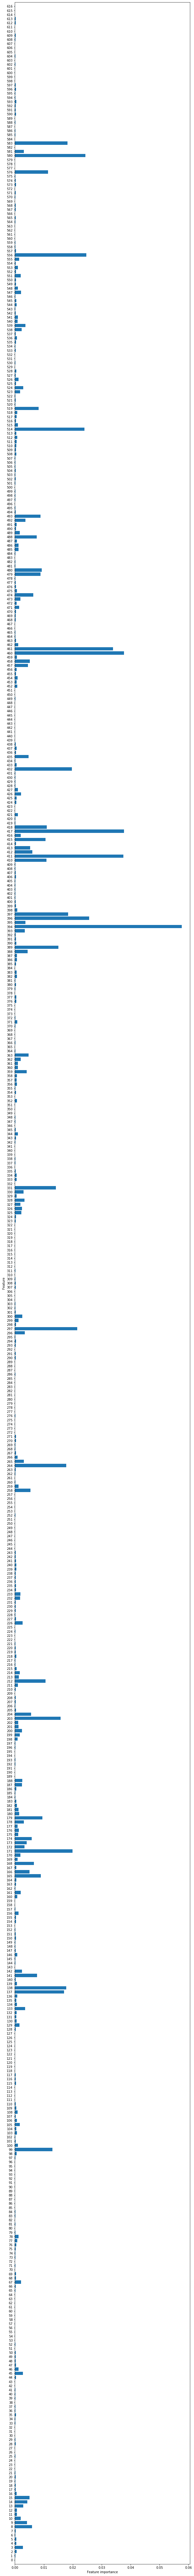

In [53]:
def plot_feature_importances(model, n_features, feature_names):
    plt.figure(figsize = (10,150))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

features = x_train.columns
plot_feature_importances(rf_clf, len(features), features)

We see from the bar graph that most of the features contribute to the model. 

The features used to classify human spoken letters were spectral coefficients; contour features, sonorant features, pre-sonorant features, and post-sonorant features. However the exact order of these features are unknown and not enclosed anywhere on the web.